In [80]:
%matplotlib inline
%pylab inline

import sys

import matplotlib.pyplot as plt
import numpy
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv

import matplotlib.cm as cm
import cv,cv2

from osgeo import gdal
from osgeo.gdalconst import *
import pp
from skimage.util.shape import view_as_windows
import time


Populating the interactive namespace from numpy and matplotlib


In [81]:
class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
        """
        Allocate a LeNetConvPoolLayer with shared variable internal parameters.

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dtensor4
        :param input: symbolic image tensor, of shape image_shape

        :type filter_shape: tuple or list of length 4
        :param filter_shape: (number of filters, num input feature maps,
                              filter height,filter width)

        :type image_shape: tuple or list of length 4
        :param image_shape: (batch size, num input feature maps,
                             image height, image width)

        :type poolsize: tuple or list of length 2
        :param poolsize: the downsampling (pooling) factor (#rows,#cols)
        """

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) /
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(numpy.asarray(
            rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
            dtype=theano.config.floatX),
                               borrow=True)

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv.conv2d(input=input, filters=self.W,
                filter_shape=filter_shape, image_shape=image_shape)

        # downsample each feature map individually, using maxpooling
        pooled_out = downsample.max_pool_2d(input=conv_out,
                                            ds=poolsize, ignore_border=True)

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1,n_filters,1,1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]


In [82]:
def evaluate_lenet5(learning_rate=0.1, n_epochs=1,
                    nkerns=[20, 50], batch_size=512*4):
    """ Demonstrates lenet on MNIST dataset

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
                          gradient)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type dataset: string
    :param dataset: path to the dataset used for training /testing (MNIST here)

    :type nkerns: list of ints
    :param nkerns: number of kernels on each layer
    """

    start_time = time.time()
    rng = numpy.random.RandomState(23455)

    TrainResult = "feedIn//tree_mask.tif"
    #TrainResult = "feedIn//shadows.tif"
    
    prbDS = gdal.Open(TrainResult, gdal.GA_Update)

    winx = 27
    winy = 27
    depth = 3
    
    tile_width = 64
    tile_height = 64
    tile_overlap = winx-1  
    

    window_shape = (winx, winy)

    #initialization of the traning feature and training result
    X = np.zeros((tile_width*tile_height,3*window_shape[0]*window_shape[1]))    
    Y = np.zeros((tile_width*tile_height,)).astype(np.int32)
    
    print Y.shape
    print X.shape
    
    def shared_dataset(data_xy, borrow=True):
        """ Function that loads the dataset into shared variables

        The reason we store our dataset in shared variables is to allow
        Theano to copy it into the GPU memory (when code is run on GPU).
        Since copying data into the GPU is slow, copying a minibatch everytime
        is needed (the default behaviour if the data is not in a shared
        variable) would lead to a large decrease in performance.
        """
        data_x, data_y = data_xy
        shared_x = theano.shared(numpy.asarray(data_x,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        shared_y = theano.shared(numpy.asarray(data_y,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        # When storing data on the GPU it has to be stored as floats
        # therefore we will store the labels as ``floatX`` as well
        # (``shared_y`` does exactly that). But during our computations
        # we need them as ints (we use labels as index, and if they are
        # floats it doesn't make sense) therefore instead of returning
        # ``shared_y`` we will have to cast it to int. This little hack
        # lets ous get around this issue
        return shared_x, T.cast(shared_y, 'int32')
        
    train_set_x, train_set_y = shared_dataset((X,Y))
    valid_set_x, valid_set_y = shared_dataset((X,Y))
    test_set_x, test_set_y = shared_dataset((X,Y))

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
    n_train_batches /= batch_size
    n_valid_batches /= batch_size
    n_test_batches /= batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')   # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels


    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print '... building the model'

    # Reshape matrix of rasterized images of shape (batch_size,winx*winy)
    # to a 4D tensor, compatible with our LeNetConvPoolLayer
    layer0_input = x.reshape((batch_size, depth, winx, winy))

    # Construct the first convolutional pooling layer:
    # filtering reduces the image size to (winx-5+1,winy-5+1)
    # maxpooling reduces this further to (winx-5+1,winy-5+1)/2
    # 4D output tensor is thus of shape (batch_size,nkerns[0],(winx-5+1,winy-5+1)/2)
    layer0 = LeNetConvPoolLayer(rng, input=layer0_input,
            image_shape=(batch_size, depth, winx, winy),
            filter_shape=(nkerns[0], 3, 5, 5), poolsize=(2, 2))

    # Construct the second convolutional pooling layer
    # the input image size after the first convolutional pooling layer is x,y = (winx-5+1,winy-5+1)/2
    # filtering reduces the image size to (x-5+1,y-5+1)
    # maxpooling reduces this further to (x-5+1,y-5+1)/2
    # 4D output tensor is thus of shape (nkerns[0],nkerns[1],(x-5+1,y-5+1)/2)
    image_size = (winx-4)/2
    layer1 = LeNetConvPoolLayer(rng, input=layer0.output,
            image_shape=(batch_size, nkerns[0], image_size, image_size),
            filter_shape=(nkerns[1], nkerns[0], 5, 5), poolsize=(2, 2))


    print "nkerns",nkerns
    # construct a fully-connected sigmoidal layer
    print image_size
    image_size = (image_size-4)/2


    # create a function to compute the mistakes that are made by the model
    test_model = theano.function([index], layer1.output.flatten(2),
             givens={
                x: test_set_x[index * batch_size: (index + 1) * batch_size],
                y: test_set_y[index * batch_size: (index + 1) * batch_size]}, on_unused_input = 'ignore')




    ###############
    # TRAIN MODEL #
    ###############
    print '... training'
    
    #here we use ANN_MLP in opencv to train the output of the second convolutional pooling layer
    ninputs = nkerns[1] * image_size * image_size
    nhidden = 50
    noutput =2
    layers = np.array([ninputs, nhidden, noutput])
    ann_model = cv2.ANN_MLP(layers, activateFunc = cv2.ANN_MLP_SIGMOID_SYM)
            
    start  = True
    
    gdal.AllRegister()

    TestDataDir     = "feedIn//rgb1.tif"
    Test_result = "feedIn//ANN_outputs1.tif"
             
    inputs = gdal.Open(TestDataDir, gdal.GA_Update)
   
    width, height = 915, 915
    
    print "Opening output files for writing...."
    
    driver = driver = gdal.GetDriverByName('GTiff')
    

    lblDS = driver.Create(Test_result, width, height, 1, gdal.GDT_Byte)
    
    if lblDS is None:
        print "Unable to create labels image"
        return
    
        
    lblDS.SetProjection(inputs.GetProjection())
    lblDS.SetGeoTransform(inputs.GetGeoTransform())

    print "Processing Tiles..."
    X, Y = np.mgrid[0:832:tile_width, 0:832:tile_height]
    tiles = zip(X.ravel(),Y.ravel())
    print "tiles =", tiles
    # tuple of all parallel python servers to connect with
#     ppservers = ()
#        ppservers = ("10.202.7.208" ,)

#     if len(sys.argv) > 1:
#         ncpus = int(sys.argv[1])
#         # Creates jobserver with ncpus workers
#         job_server = pp.Server(ncpus, ppservers=ppservers)
#     else:
#         # Creates jobserver with automatically detected number of workers
#         job_server = pp.Server(ppservers=ppservers)
#     jobs = []
#     print job_server.get_active_nodes()
    
    lblBand = lblDS.GetRasterBand(1)
    
    def on_tile_finished(tiles,  i, result):
        
        trees = result
        
        tile_x, tile_y = tiles[i]
        tile_x, tile_y = int(tile_x), int(tile_y)
        

        lblBand.WriteArray(trees, xoff=tile_x, yoff=tile_y)
       
    print "training...."
    
    train_number = 9
    iterations = 3
    #we choose the first train_number tiles as the training data 
    train_num = 2
    for j in range(iterations):
        print "iteration", j
        for i in range(train_number):
            print "train_number =", i
#             if(i == 2):
#                 train_num = 60
            tile_x, tile_y = tiles[i+train_num]    
            tile_x, tile_y = int(tile_x), int(tile_y)
            
            xs = min(tile_width + tile_overlap, width-tile_x)
            ys = min(tile_height + tile_overlap, height-tile_y) 
            print "tile_x:", tile_x
            print "tile_y:", tile_y
            print "xs:", xs
            print "ys:", ys
            
            data = inputs.ReadAsArray(xoff=tile_x,
                            yoff=tile_y,
                            xsize=xs,
                            ysize=ys)
    
            data = data.transpose((1,2,0)).astype(np.float32)

            prob_data = prbDS.ReadAsArray(xoff = tile_x,
                                          yoff = tile_y,
                                          xsize = xs,
                                          ysize = ys)
                        
            if(len(prob_data.shape)==3):                          
                prob_data = prob_data.transpose((1,0,2)).astype(np.float32)
            print "prob_data", prob_data
            for p in range(xs):
                for q in range(ys):
                    if(prob_data[p][q] >= 1):
                         prob_data[p][q] = 255
                    else:
                        prob_data[p][q] = 0

            xs = min(tile_width, width-tile_x)
            ys = min(tile_height, height-tile_y)

            #Find trees....
            print "Extracting Treess...."
            window_shape = (winx, winy)
            B = view_as_windows(data, (winx,winy,depth))
            r,c,s,w,h,d = B.shape
            print B.shape

            plt.subplot(2,3,1)
            plt.axis('off')
            plt.imshow(data[winx/2:winx/2+r,winy/2:winy/2+c]/255.0)
            
            prob_data = prob_data[winx/2:winx/2+r,winy/2:winy/2+c]
            
            X = np.reshape(B,(r*c,3*window_shape[0]*window_shape[1]))
            Y = prob_data.flatten()
            Y = np.reshape(Y,(r*c)).astype(np.int32)
            
            print X.shape
            print Y.shape

            test_set_x.set_value(numpy.asarray(X,dtype=theano.config.floatX),borrow=True)
            n_test_batches = test_set_x.get_value(borrow=True).shape[0]
            n_test_batches /= batch_size
            print "Training Tile = ", i
                
            for i in xrange(n_test_batches):
                print "n_test_batches =  ", n_test_batches
                sample = test_model(i)
                condition = cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS
                nsteps = 200
                max_err = 0.001
                criteria = (condition, nsteps, max_err)
                para = dict( term_crit = criteria, 
                   train_method = cv2.ANN_MLP_TRAIN_PARAMS_BACKPROP, 
                   bp_dw_scale = 0.01, 
                   bp_moment_scale = 0.1 )
                   
                label = Y[i * batch_size: (i + 1) * batch_size]
                
                labels = np.zeros((sample.shape[0],noutput))
                labels[:,0] = np.reshape(label.max() -label,(sample.shape[0],1)).T
                labels[:,1] = np.reshape(label,(sample.shape[0],1)).T
                labels/= labels.max()
                print "sample shape =",sample.shape
                print "labels shape =",labels.shape
                if start is True:
                    print sample.shape,labels.shape
                    ann_model.train(sample,labels,None,params=para)                
                else:
                    ann_model.train(sample,labels,None,params=para,flags = cv2.ANN_MLP_UPDATE_WEIGHTS )
                    
                start = False
                
        print "Training program took", time.time() - start_time, "to run"
        
        print "begin validation..."
        
        error = 0
        for i in range(train_number):
            
            tile_x, tile_y = tiles[i]
            tile_x, tile_y = int(tile_x), int(tile_y)
            
            xs = min(tile_width + tile_overlap, width-tile_x)
            ys = min(tile_height + tile_overlap, height-tile_y) 
            
            data = inputs.ReadAsArray(xoff=tile_x,
                            yoff=tile_y,
                            xsize=xs,
                            ysize=ys)
    
            data = data.transpose((1,2,0)).astype(np.float32)

            prob_data = prbDS.ReadAsArray(xoff = tile_x,
                                          yoff = tile_y,
                                          xsize = xs,
                                          ysize = ys)
               
            if(len(prob_data.shape)==3):                          
                prob_data = prob_data.transpose((1,2,0)).astype(np.float32)
            
            
            xs = min(tile_width, width-tile_x)
            ys = min(tile_height, height-tile_y)
            
            #Find trees....
            print "Extracting Trees...."
            window_shape = (winx, winy)
            B = view_as_windows(data, (winx,winy,depth))
            r,c,s,w,h,d = B.shape
            print B.shape
            
            plt.subplot(2,3,1)
            plt.axis('off')
            plt.imshow(data[winx/2:winx/2+r,winy/2:winy/2+c]/255.0)
            
            prob_data = prob_data[winx/2:winx/2+r,winy/2:winy/2+c]
            
            X = np.reshape(B,(r*c,3*window_shape[0]*window_shape[1]))
            Y = prob_data.flatten()
            Y = np.reshape(Y,(r*c)).astype(np.int32)
            
            new_test_set_x = theano.shared(numpy.asarray(X,dtype=theano.config.floatX), borrow=True)
            
            n_test_batches = new_test_set_x.get_value(borrow=True).shape[0]
            n_test_batches /= batch_size
            test_set_x.set_value(numpy.asarray(X,dtype=theano.config.floatX),borrow=True)
    #        test_set_y.set_value(numpy.asarray(Y,dtype=theano.config.floatX),borrow=True)           
            result = []   
            for j in xrange(n_test_batches):    
                sample = test_model(j)
                predictions = np.empty((sample.shape[0],2))
                print "Sample shape =", sample.shape[0]
                g, prediction = ann_model.predict(sample,predictions)
                pred_labels = np.argmax( prediction, axis=1 )
                result.append(pred_labels)
                
            pred = np.reshape(result, (r,c))
            error += np.mean(pred.astype(np.uint8) ^ prob_data.astype(np.uint8))
            print "tile ",i,"error ", np.mean(pred.astype(np.uint8) ^ prob_data.astype(np.uint8))
            plt.axis('off')
            plt.subplot(2,3,2)
            plt.axis('off')
            plt.imshow(prob_data,cmap =cm.gray)
            
            
            plt.subplot(2,3,3)
            plt.axis('off')
            plt.imshow(pred,cmap =cm.gray)
            plt.show()
        print "validation error",error/train_number     
            
    print "testing..."  
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    print "testing..."
    all_tiles_time = time.time()
    for i in range(len(tiles)):
        print "tile num =", i
        tile_time = time.time()
        
        tile_x, tile_y = tiles[i]
        tile_x, tile_y = int(tile_x), int(tile_y)
        
        xs = min(tile_width + tile_overlap, width-tile_x)
        ys = min(tile_height + tile_overlap, height-tile_y) 
        
        data = inputs.ReadAsArray(xoff=tile_x,
                        yoff=tile_y,
                        xsize=xs,
                        ysize=ys)

        data = data.transpose((1,2,0)).astype(np.float32)
        
        prob_data = prbDS.ReadAsArray(xoff = tile_x,
                                  yoff = tile_y,
                                  xsize = xs,
                                  ysize = ys) 
                                         
        if(len(prob_data.shape)==3):                          
                prob_data = prob_data.transpose((1,2,0)).astype(np.float32)
                                  
                                  
        
        xs = min(tile_width, width-tile_x)
        ys = min(tile_height, height-tile_y)

        
        #Find trees....
        window_shape = (winx, winy)
        B = view_as_windows(data, (winx,winy,depth))
        r,c,s,w,h,d = B.shape
        
        prob_data = prob_data[winx/2:winx/2+r,winy/2:winy/2+c]
        
        X = np.reshape(B,(r*c,3*window_shape[0]*window_shape[1]))
                
        plt.subplot(1,3,1)
        plt.title("original")
        plt.axis('off')
        plt.imshow(data[winx/2:winx/2+r,winy/2:winy/2+c]/255.0)
        
        new_test_set_x = theano.shared(numpy.asarray(X,dtype=theano.config.floatX), borrow=True)
        
        n_test_batches = new_test_set_x.get_value(borrow=True).shape[0]
        n_test_batches /= batch_size
        test_set_x.set_value(numpy.asarray(X,dtype=theano.config.floatX),borrow=True)
        result = []
        for j in xrange(n_test_batches):     
            sample = test_model(j)
            predictions = np.empty((sample.shape[0],2))
            g, prediction = ann_model.predict(sample,predictions)
            pred_labels = np.argmax( prediction, axis=1 )
            result.append(pred_labels)
        
        print "result shape", result
        print "r, c shape", r, c
        pred = np.reshape(result, (r,c))
        on_tile_finished(tiles,i,pred)

        print "Tile prediction took", time.time() - tile_time, "to run"
        
        plt.subplot(1,3,2)
        plt.title("prob_data")
        plt.axis('off')
        plt.imshow(prob_data,cmap =cm.gray)
        
        plt.subplot(1,3,3)
        plt.title("pred")
        plt.axis('off')
        plt.imshow(pred,cmap =cm.gray)
                
        fig1 = plt.gcf()
        plt.show()
        fig1.savefig("%d__%d.tif"%(tile_x,tile_y))
#         plt.show()
#         plt.savefig("%d_%d.png"%(tile_x,tile_y))

    print "All tiles processing took", time.time() - all_tiles_time, "to run"
    
    lblBand.FlushCache()
    lblBand = None 
    lblDS = None
    del lblDS

(4096,)
(4096, 2187)
... building the model
nkerns [20, 50]
11
... training
Opening output files for writing....
Processing Tiles...
tiles = [(0, 0), (0, 64), (0, 128), (0, 192), (0, 256), (0, 320), (0, 384), (0, 448), (0, 512), (0, 576), (0, 640), (0, 704), (0, 768), (64, 0), (64, 64), (64, 128), (64, 192), (64, 256), (64, 320), (64, 384), (64, 448), (64, 512), (64, 576), (64, 640), (64, 704), (64, 768), (128, 0), (128, 64), (128, 128), (128, 192), (128, 256), (128, 320), (128, 384), (128, 448), (128, 512), (128, 576), (128, 640), (128, 704), (128, 768), (192, 0), (192, 64), (192, 128), (192, 192), (192, 256), (192, 320), (192, 384), (192, 448), (192, 512), (192, 576), (192, 640), (192, 704), (192, 768), (256, 0), (256, 64), (256, 128), (256, 192), (256, 256), (256, 320), (256, 384), (256, 448), (256, 512), (256, 576), (256, 640), (256, 704), (256, 768), (320, 0), (320, 64), (320, 128), (320, 192), (320, 256), (320, 320), (320, 384), (320, 448), (320, 512), (320, 576), (320, 640), (32

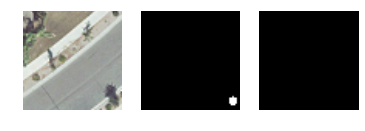

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  1 error  0.0


Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  2 error  95.5004882812


Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  3 error  92.0764160156


Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  4 error  101.975097656


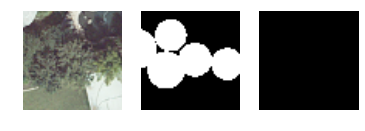

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  5 error  39.4079589844


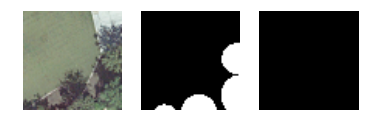

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  6 error  52.9174804688


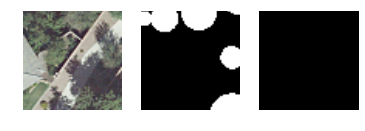

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  7 error  36.5441894531


Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  8 error  25.0268554688


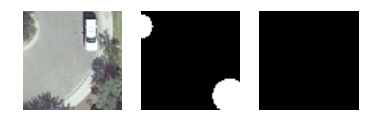

validation error 49.4380696615
iteration 1
train_number = 0
tile_x: 0
tile_y: 128
xs: 90
ys: 90
prob_data [[  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 ..., 
 [  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]]
Extracting Treess....
(64, 64, 1, 27, 27, 3)
(4096, 2187)
(4096,)
Training Tile =  0
n_test_batches =   2
sample shape = (2048, 450)
labels shape = (2048, 2)
n_test_batches =   2
sample shape = (2048, 450)
labels shape = (2048, 2)
train_number = 1
tile_x: 0
tile_y: 192
xs: 90
ys: 90
prob_data [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
Extracting Treess....
(64, 64, 1, 27, 27, 3)
(4096, 2187)
(4096,)
Training Tile =  1
n_test_batches =   2
sample shape = (2048, 450)
labels shape = (2048, 2)
n_test_batches =   2
sample shape = (2048, 450)
labels shape = (2048, 2)
train_number = 2
tile_x: 0
tile_y: 256
xs

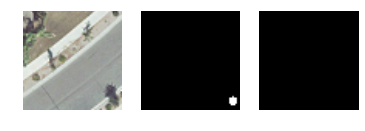

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  1 error  0.0


Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  2 error  95.5004882812


Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  3 error  92.0764160156


Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  4 error  101.975097656


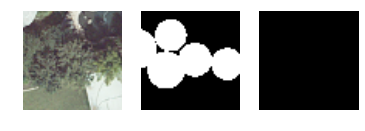

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  5 error  39.4079589844


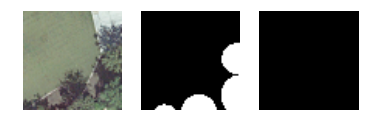

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  6 error  52.9174804688


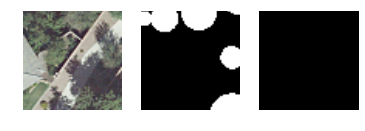

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  7 error  36.5441894531


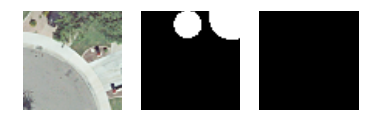

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  8 error  25.0268554688


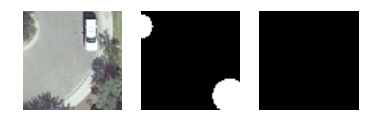

validation error 49.4380696615
iteration 2
train_number = 0
tile_x: 0
tile_y: 128
xs: 90
ys: 90
prob_data [[  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 ..., 
 [  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]]
Extracting Treess....
(64, 64, 1, 27, 27, 3)
(4096, 2187)
(4096,)
Training Tile =  0
n_test_batches =   2
sample shape = (2048, 450)
labels shape = (2048, 2)
n_test_batches =   2
sample shape = (2048, 450)
labels shape = (2048, 2)
train_number = 1
tile_x: 0
tile_y: 192
xs: 90
ys: 90
prob_data [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
Extracting Treess....
(64, 64, 1, 27, 27, 3)
(4096, 2187)
(4096,)
Training Tile =  1
n_test_batches =   2
sample shape = (2048, 450)
labels shape = (2048, 2)
n_test_batches =   2
sample shape = (2048, 450)
labels shape = (2048, 2)
train_number = 2
tile_x: 0
tile_y: 256
xs

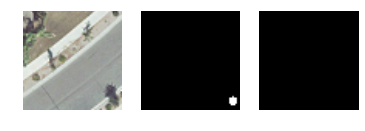

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  1 error  0.0


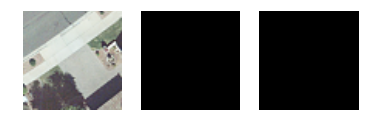

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  2 error  95.5004882812


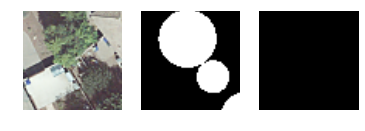

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  3 error  92.0764160156


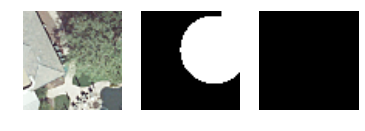

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  4 error  101.975097656


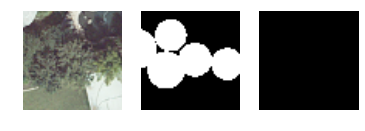

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  5 error  39.4079589844


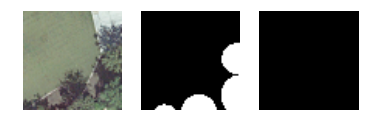

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  6 error  52.9174804688


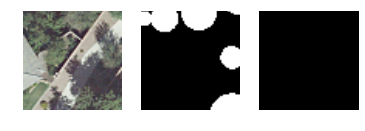

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  7 error  36.5441894531


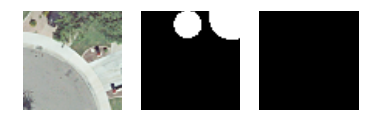

Extracting Trees....
(64, 64, 1, 27, 27, 3)
Sample shape = 2048
Sample shape = 2048
tile  8 error  25.0268554688


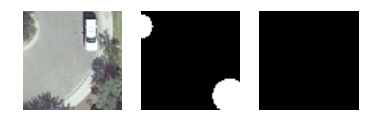

validation error 49.4380696615
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
testing...
tile num = 0
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 5.17588615417 to run


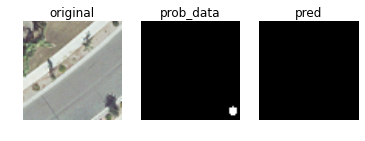

tile num = 1
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81198716164 to run


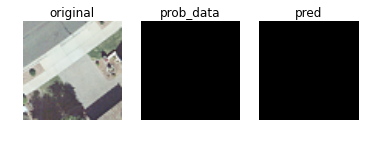

tile num = 2
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.89717817307 to run


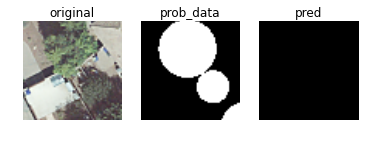

tile num = 3
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86483192444 to run


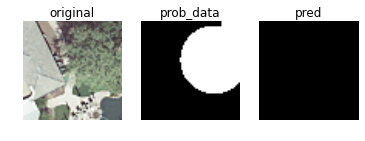

tile num = 4
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.77569699287 to run


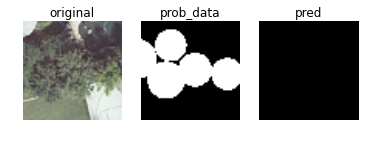

tile num = 5
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.98852610588 to run


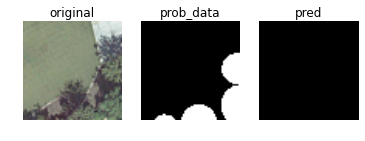

tile num = 6
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86059117317 to run


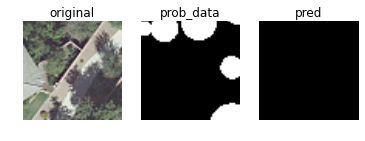

tile num = 7
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80669093132 to run


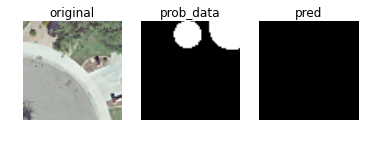

tile num = 8
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83542704582 to run


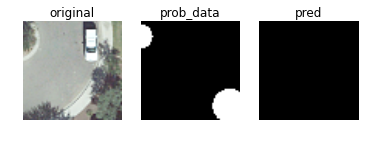

tile num = 9
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85557603836 to run


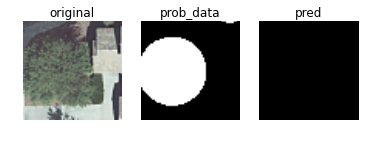

tile num = 10
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.87005805969 to run


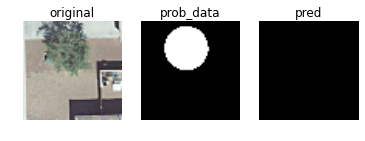

tile num = 11
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86987614632 to run


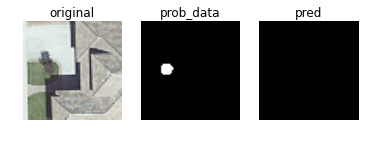

tile num = 12
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81771922112 to run


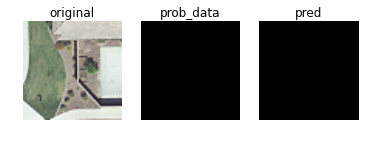

tile num = 13
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.84929513931 to run


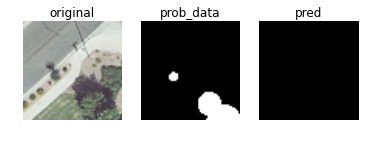

tile num = 14
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83336901665 to run


tile num = 15
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83054995537 to run


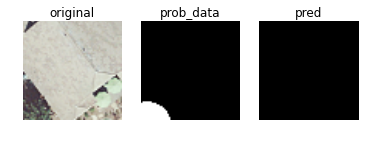

tile num = 16
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.99284386635 to run


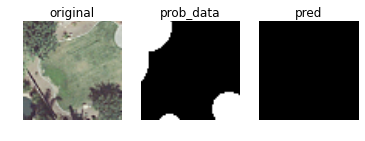

tile num = 17
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86249804497 to run


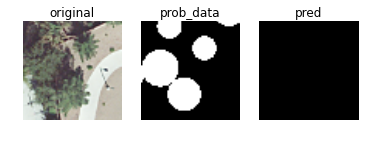

tile num = 18
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83436703682 to run


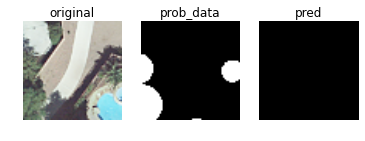

tile num = 19
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.89240193367 to run


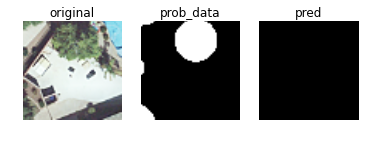

tile num = 20
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79105305672 to run


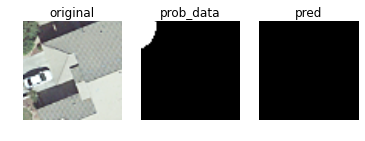

tile num = 21
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83708000183 to run


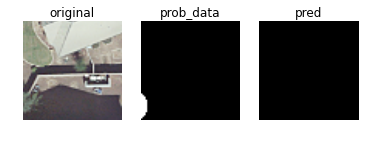

tile num = 22
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80244398117 to run


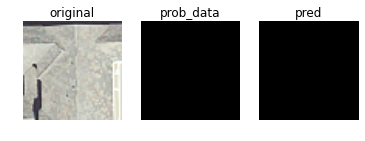

tile num = 23
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82789301872 to run


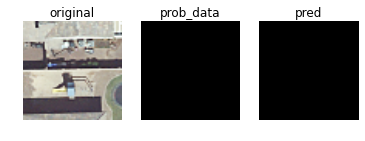

tile num = 24
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.88591122627 to run


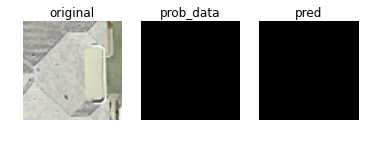

tile num = 25
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.8639729023 to run


tile num = 26
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.77953791618 to run


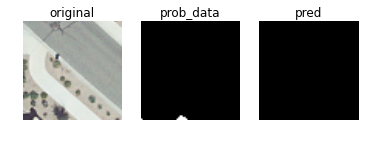

tile num = 27
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 5.04098701477 to run


tile num = 28
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82096385956 to run


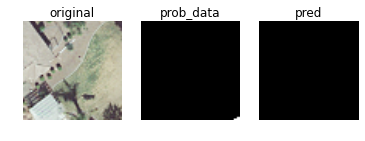

tile num = 29
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.89333486557 to run


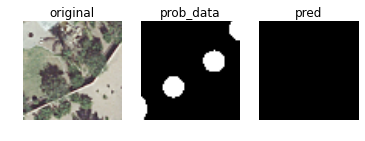

tile num = 30
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81640195847 to run


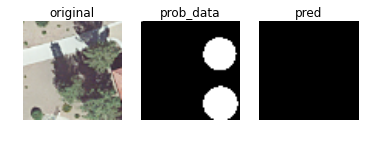

tile num = 31
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.7837638855 to run


tile num = 32
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86893105507 to run


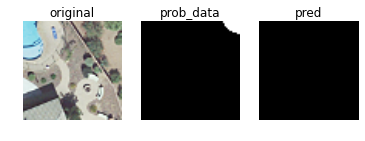

tile num = 33
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79467797279 to run


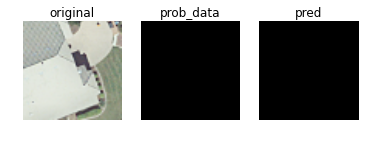

tile num = 34
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81284499168 to run


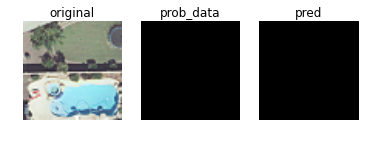

tile num = 35
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.8451859951 to run


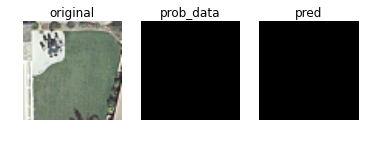

tile num = 36
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83787417412 to run


tile num = 37
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.75998401642 to run


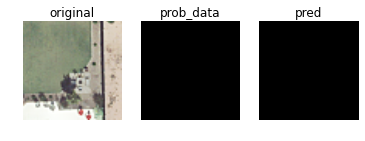

tile num = 38
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.91406083107 to run


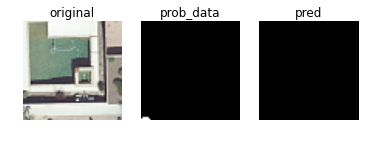

tile num = 39
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79167199135 to run


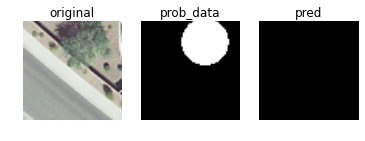

tile num = 40
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86358380318 to run


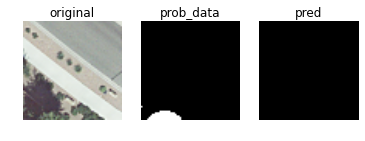

tile num = 41
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78150105476 to run


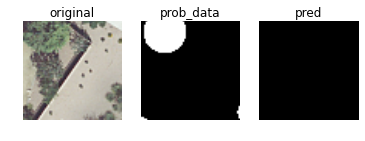

tile num = 42
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82044291496 to run


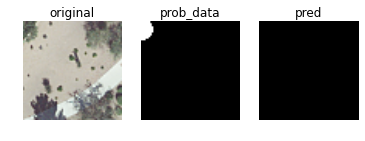

tile num = 43
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.77661705017 to run


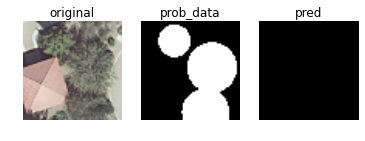

tile num = 44
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79336118698 to run


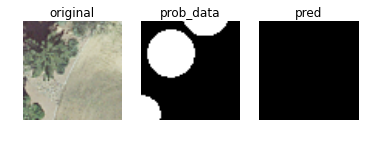

tile num = 45
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81949591637 to run


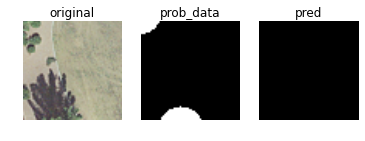

tile num = 46
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85378098488 to run


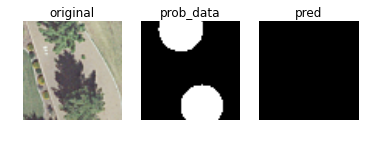

tile num = 47
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86832809448 to run


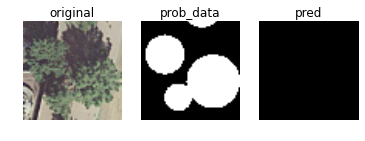

tile num = 48
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.88909196854 to run


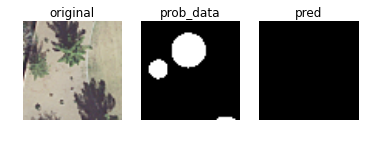

tile num = 49
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 5.00547814369 to run


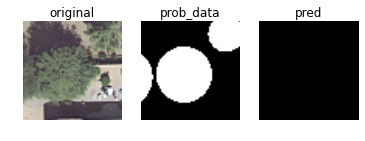

tile num = 50
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.87682795525 to run


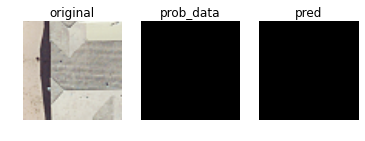

tile num = 51
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82944893837 to run


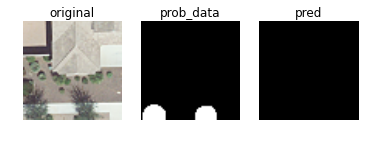

tile num = 52
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85501599312 to run


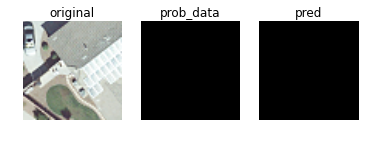

tile num = 53
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.8097679615 to run


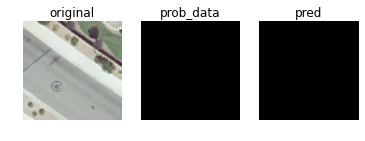

tile num = 54
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83109807968 to run


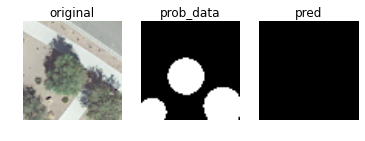

tile num = 55
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81835007668 to run


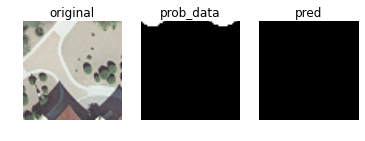

tile num = 56
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79802894592 to run


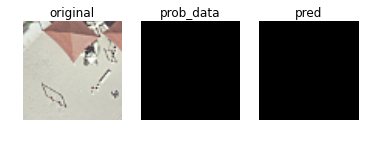

tile num = 57
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.74576091766 to run


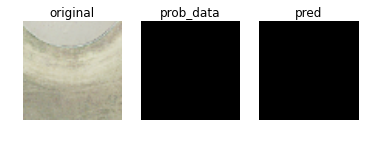

tile num = 58
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.74473905563 to run


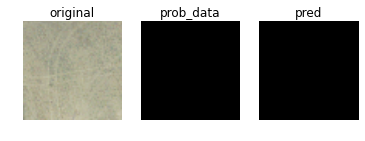

tile num = 59
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.76824498177 to run


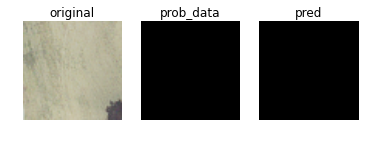

tile num = 60
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.89745998383 to run


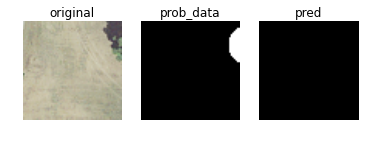

tile num = 61
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79803609848 to run


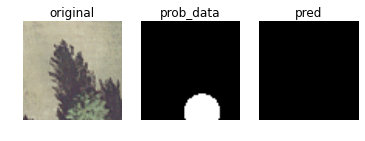

tile num = 62
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.84666514397 to run


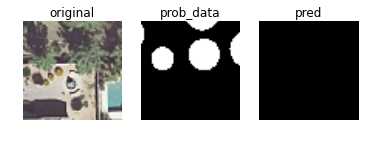

tile num = 63
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82718205452 to run


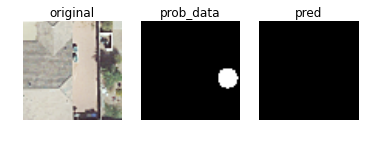

tile num = 64
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.77645397186 to run


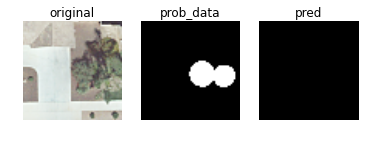

tile num = 65
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82115006447 to run


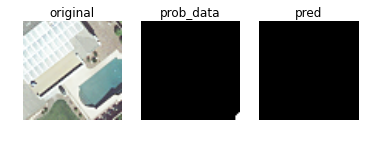

tile num = 66
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.7933549881 to run


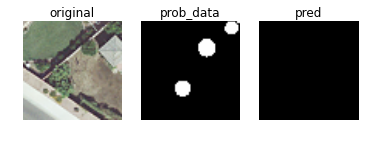

tile num = 67
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86118292809 to run


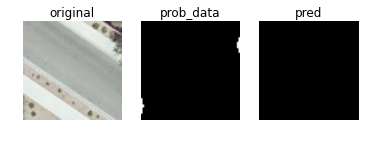

tile num = 68
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80159187317 to run


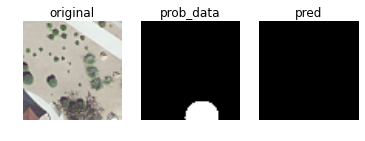

tile num = 69
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82186794281 to run


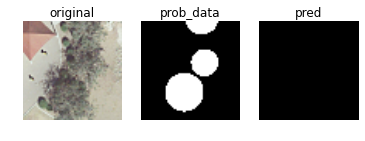

tile num = 70
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78082609177 to run


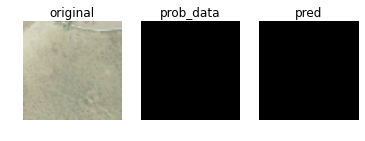

tile num = 71
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.90181207657 to run


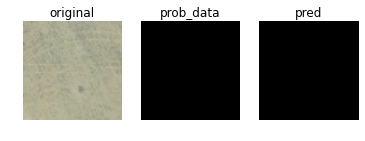

tile num = 72
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.75685787201 to run


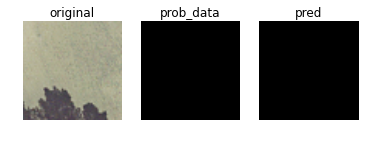

tile num = 73
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80933308601 to run


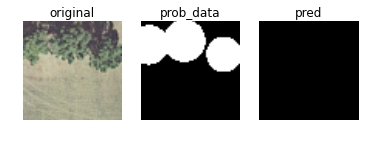

tile num = 74
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79220080376 to run


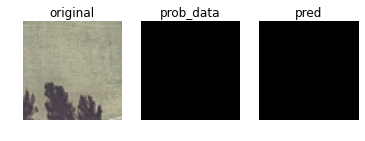

tile num = 75
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.8144299984 to run


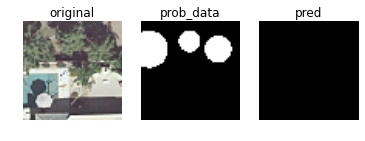

tile num = 76
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86212897301 to run


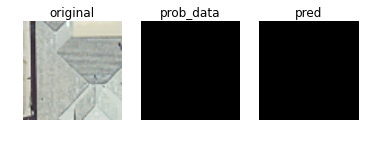

tile num = 77
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.76880812645 to run


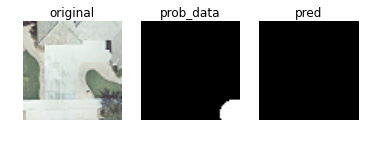

tile num = 78
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.90283083916 to run


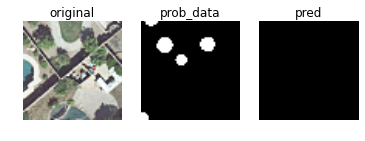

tile num = 79
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82238602638 to run


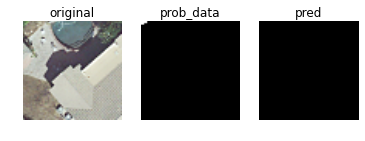

tile num = 80
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.76969504356 to run


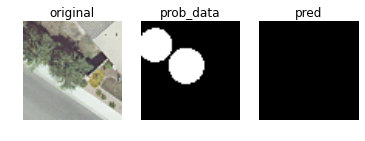

tile num = 81
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.84171199799 to run


tile num = 82
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.91352295876 to run


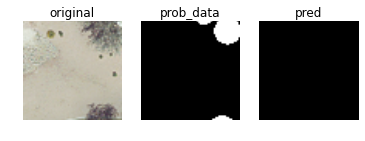

tile num = 83
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.74482917786 to run


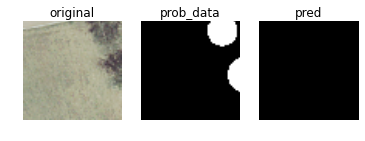

tile num = 84
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.76004004478 to run


tile num = 85
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80375790596 to run


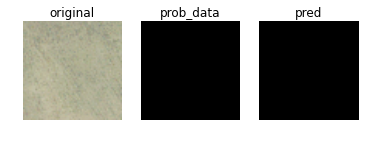

tile num = 86
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78828787804 to run


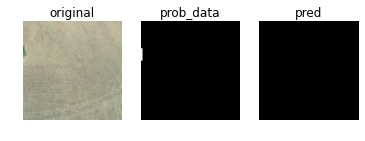

tile num = 87
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.70712685585 to run


tile num = 88
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.84079504013 to run


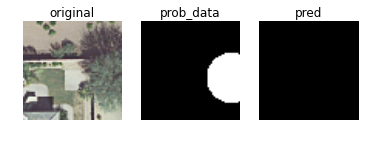

tile num = 89
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.76768517494 to run


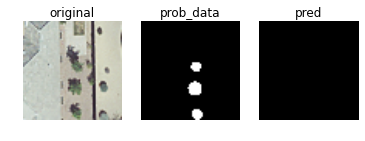

tile num = 90
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82369184494 to run


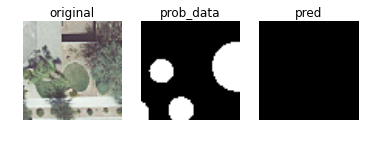

tile num = 91
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81575298309 to run


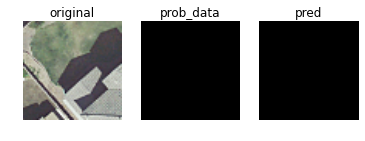

tile num = 92
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78598403931 to run


tile num = 93
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.95625114441 to run


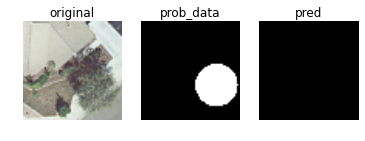

tile num = 94
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85394287109 to run


tile num = 95
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80960202217 to run


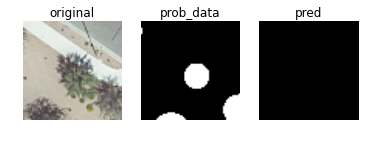

tile num = 96
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78379392624 to run


tile num = 97
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.7697019577 to run


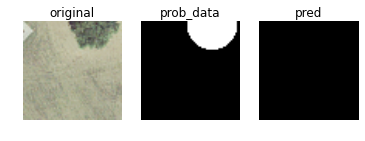

tile num = 98
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81296300888 to run


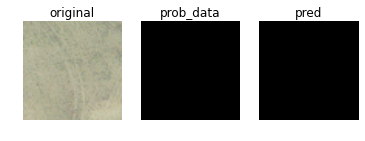

tile num = 99
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83138895035 to run


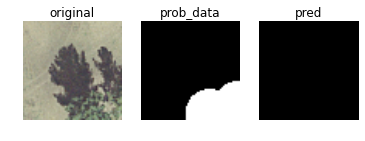

tile num = 100
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.75318908691 to run


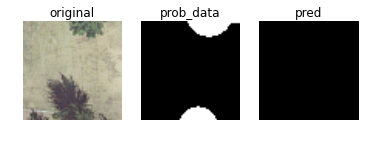

tile num = 101
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81523108482 to run


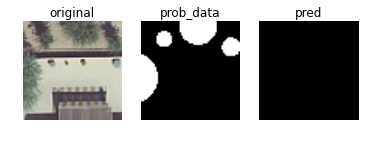

tile num = 102
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82837486267 to run


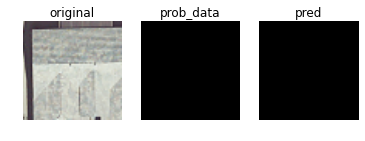

tile num = 103
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83014202118 to run


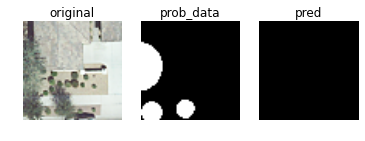

tile num = 104
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.9722840786 to run


tile num = 105
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85727095604 to run


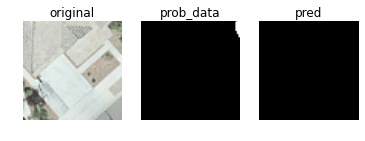

tile num = 106
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86538696289 to run


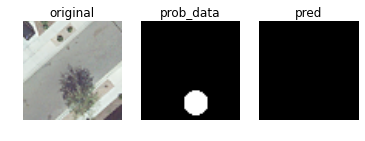

tile num = 107
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81450605392 to run


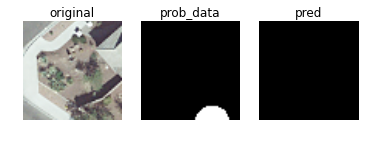

tile num = 108
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80795693398 to run


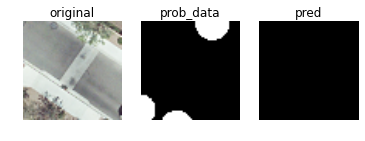

tile num = 109
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83710193634 to run


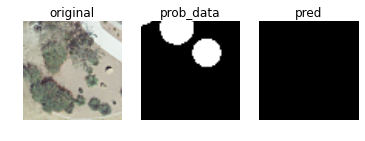

tile num = 110
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79909205437 to run


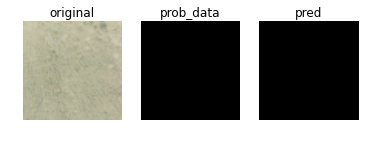

tile num = 111
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.75793910027 to run


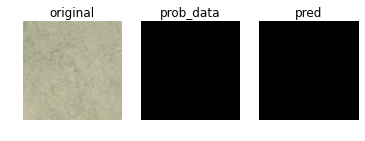

tile num = 112
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79997801781 to run


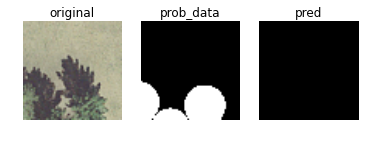

tile num = 113
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85311889648 to run


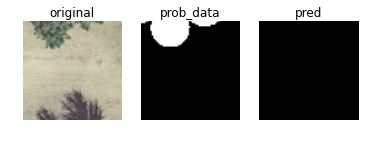

tile num = 114
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79633688927 to run


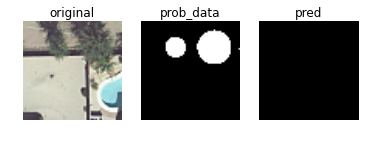

tile num = 115
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.93120098114 to run


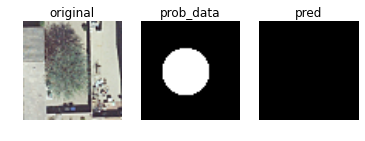

tile num = 116
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83715510368 to run


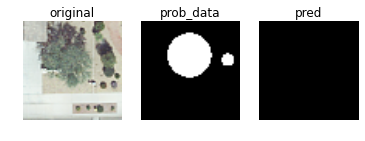

tile num = 117
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82014203072 to run


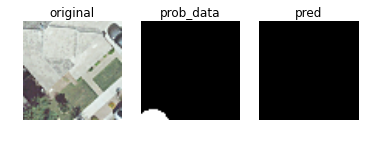

tile num = 118
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.88318896294 to run


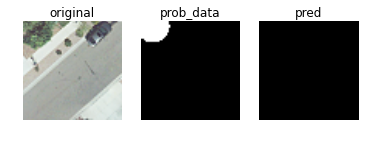

tile num = 119
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.77108001709 to run


tile num = 120
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86043381691 to run


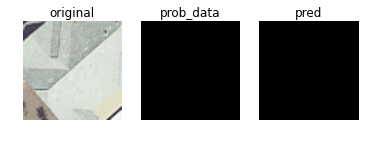

tile num = 121
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.84283995628 to run


tile num = 122
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78669595718 to run


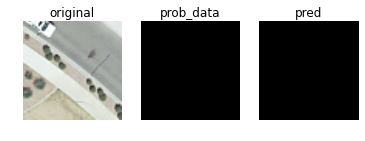

tile num = 123
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79036998749 to run


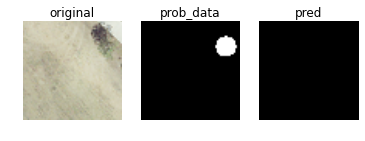

tile num = 124
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79972410202 to run


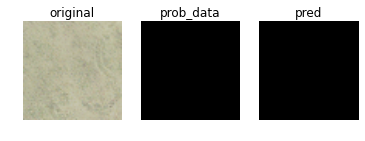

tile num = 125
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79268598557 to run


tile num = 126
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.96118497849 to run


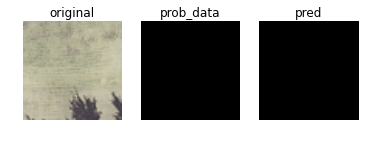

tile num = 127
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85501909256 to run


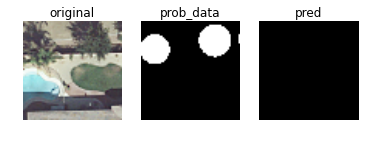

tile num = 128
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81398487091 to run


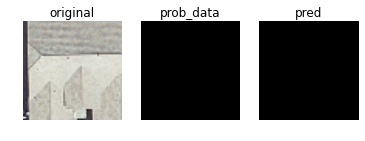

tile num = 129
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81243085861 to run


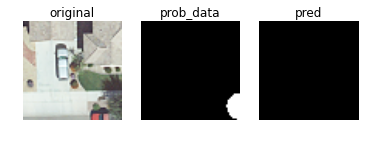

tile num = 130
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85706210136 to run


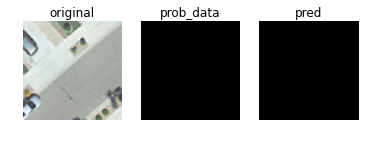

tile num = 131
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.81824994087 to run


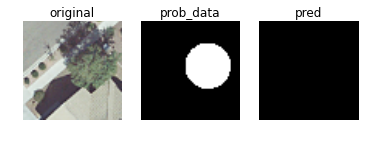

tile num = 132
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79684519768 to run


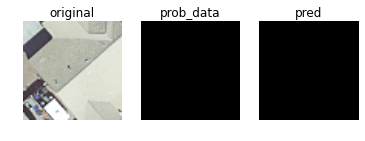

tile num = 133
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.84019303322 to run


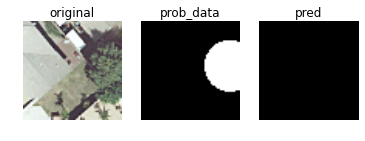

tile num = 134
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80890512466 to run


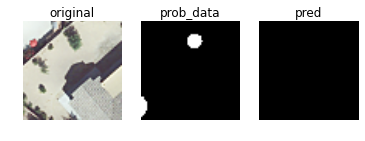

tile num = 135
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86598300934 to run


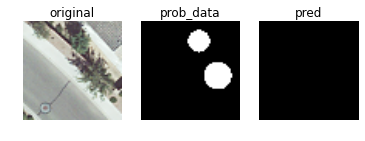

tile num = 136
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.73956894875 to run


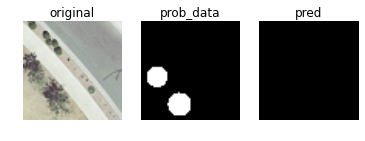

tile num = 137
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.97357797623 to run


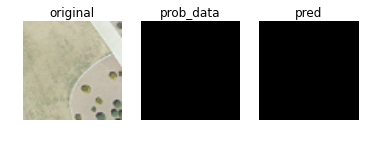

tile num = 138
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82316112518 to run


tile num = 139
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.77412295341 to run


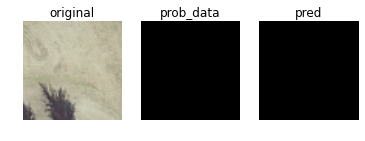

tile num = 140
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78665089607 to run


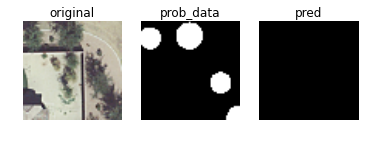

tile num = 141
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82857513428 to run


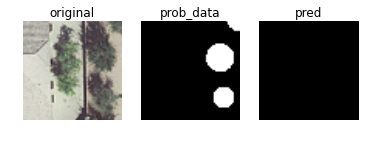

tile num = 142
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.85522603989 to run


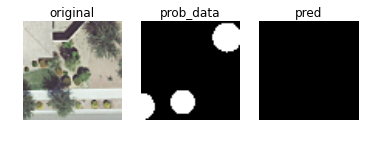

tile num = 143
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80010795593 to run


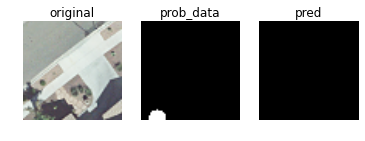

tile num = 144
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83401894569 to run


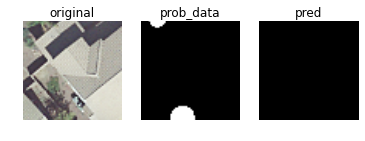

tile num = 145
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.84315705299 to run


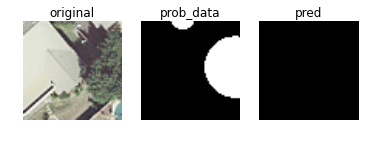

tile num = 146
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.82443094254 to run


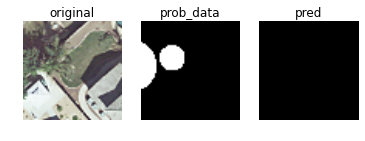

tile num = 147
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.87425613403 to run


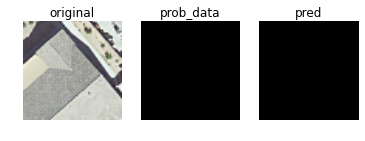

tile num = 148
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 5.01042413712 to run


tile num = 149
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79229807854 to run


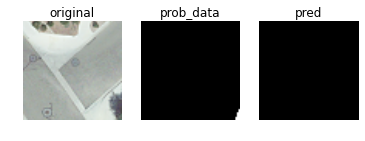

tile num = 150
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.77477788925 to run


tile num = 151
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78364491463 to run


tile num = 152
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.87386894226 to run


tile num = 153
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.78753209114 to run


tile num = 154
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.87501001358 to run


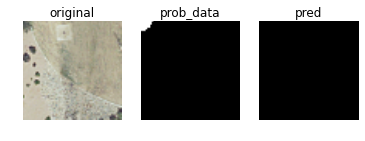

tile num = 155
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83739995956 to run


tile num = 156
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.87701702118 to run


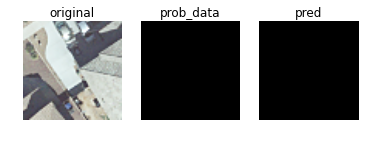

tile num = 157
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.89365196228 to run


tile num = 158
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.84671497345 to run


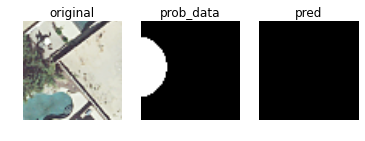

tile num = 159
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.94451999664 to run


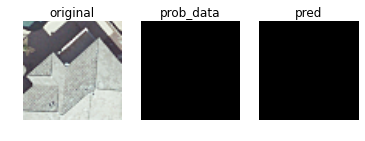

tile num = 160
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79119610786 to run


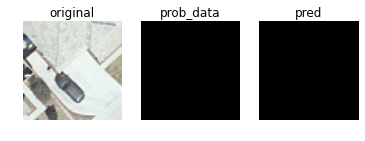

tile num = 161
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.74784111977 to run


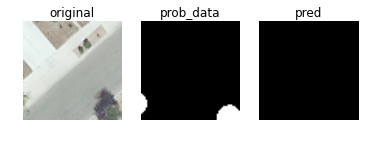

tile num = 162
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.89359402657 to run


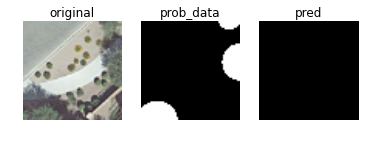

tile num = 163
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.86898708344 to run


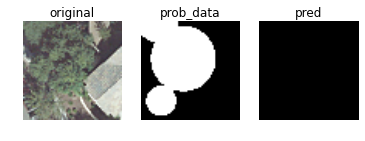

tile num = 164
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.79121398926 to run


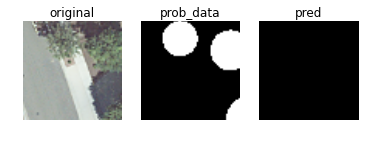

tile num = 165
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80529713631 to run


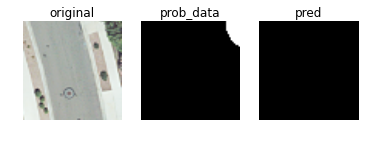

tile num = 166
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.83706998825 to run


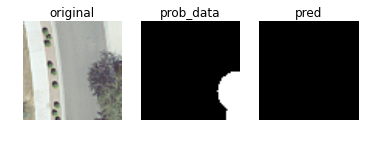

tile num = 167
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.80922889709 to run


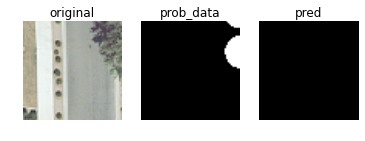

tile num = 168
result shape [array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]
r, c shape 64 64
Tile prediction took 4.74958086014 to run


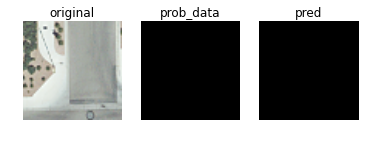

All tiles processing took 875.895239115 to run


In [83]:
get_ipython().profile
evaluate_lenet5()